In [3]:
#!unzip file.zip

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [5]:
base_dir = '/content/Dataset'
categories = ['Bacterial blight', 'Brown spot', 'Leaf smut']

In [6]:
def load_images(base_dir, categories, img_size=(128, 128)):
    images = []
    labels = []
    for category in categories:
        category_path = os.path.join(base_dir, category)
        for filename in os.listdir(category_path):
            if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
                img_path = os.path.join(category_path, filename)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, img_size)
                images.append(img)
                labels.append(category)
    return np.array(images), np.array(labels)

images, labels = load_images(base_dir, categories)

In [7]:
def display_sample_images(images, labels, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        idx = np.random.randint(len(images))
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[idx])
        plt.title(class_names[labels[idx]])
        plt.axis('off')
    plt.show()

In [8]:
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
labels_encoded = to_categorical(labels_encoded)

In [9]:
images = images / 255.0

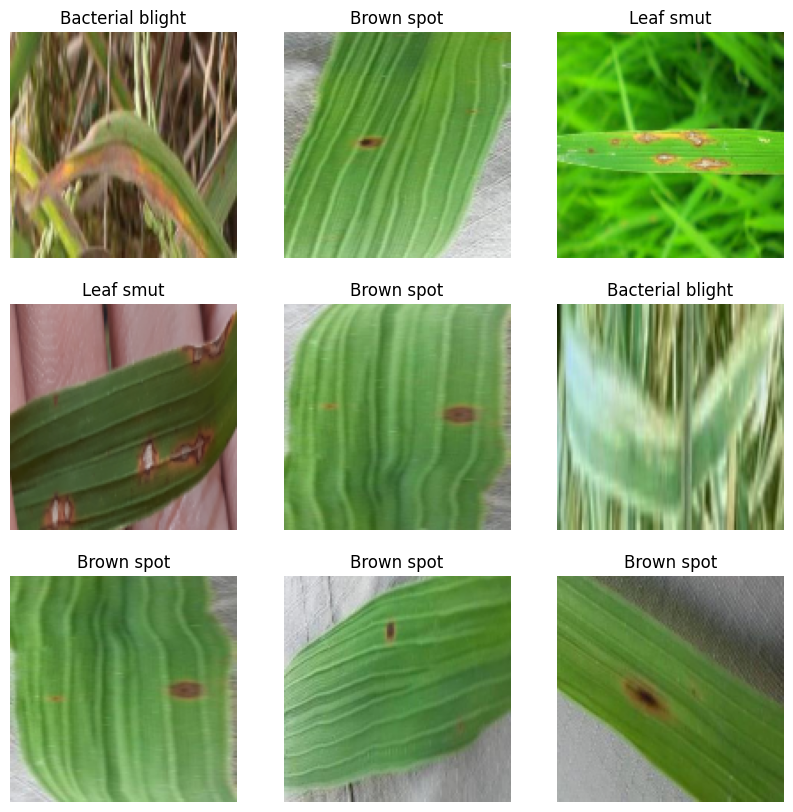

In [10]:
class_names = le.classes_
display_sample_images(images, labels_encoded.argmax(axis=1), class_names)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=0.35, random_state=42)

In [12]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

In [13]:
from tensorflow.keras.applications import VGG16
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

model = Sequential()
model.add(vgg_base)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(categories), activation='softmax'))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
vgg_base.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    epochs=50,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


80/80 ━━━━━━━━━━━━━━━━━━━━ 36s 324ms/step - accuracy: 0.5943 - loss: 1.4423 - val_accuracy: 0.8374 - val_loss: 0.4270 - learning_rate: 0.0010
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 169ms/step - accuracy: 0.8019 - loss: 0.4781 - val_accuracy: 0.8432 - val_loss: 0.3873 - learning_rate: 0.0010
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 167ms/step - accuracy: 0.8227 - loss: 0.4530 - val_accuracy: 0.8886 - val_loss: 0.2846 - learning_rate: 0.0010
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 157ms/step - accuracy: 0.8706 - loss: 0.3490 - val_accuracy: 0.9004 - val_loss: 0.2769 - learning_rate: 0.0010
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 156ms/step - accuracy: 0.8700 - loss: 0.3328 - val_accuracy: 0.8908 - val_loss: 0.2925 - learning_rate: 0.0010
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 158ms/step - accuracy: 0.8821 - loss: 0.3011 - val_accuracy: 0.9128 - val_loss: 0.2434 - learning_rate: 0.0010
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 13s 157ms/step - accuracy: 0.9012 - loss: 0.2885 - val_

In [16]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.9884 - loss: 0.0341
Test Accuracy: 98.53%


In [17]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step


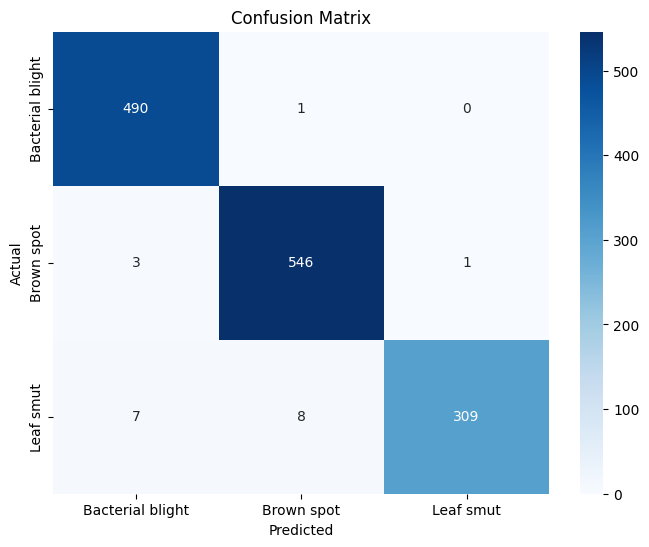

In [18]:
conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [19]:
class_report = classification_report(y_true, y_pred_classes, target_names=class_names)
print('Classification Report:')
print(class_report)

Classification Report:
                  precision    recall  f1-score   support

Bacterial blight       0.98      1.00      0.99       491
      Brown spot       0.98      0.99      0.99       550
       Leaf smut       1.00      0.95      0.97       324

        accuracy                           0.99      1365
       macro avg       0.99      0.98      0.98      1365
    weighted avg       0.99      0.99      0.99      1365



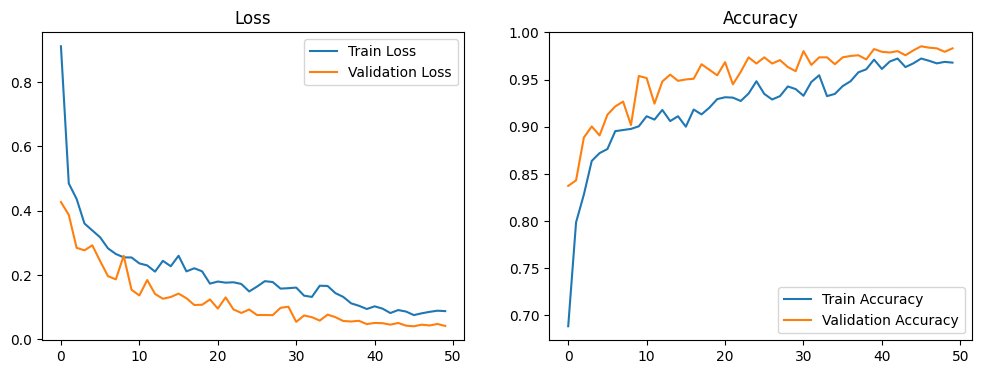

In [20]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

In [21]:
model.save('model.keras')